In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical

In [3]:
#read DataSet
train_image="/kaggle/input/chest-xray-covid19-pneumonia/Data/train/"
test_image="/kaggle/input/chest-xray-covid19-pneumonia/Data/test/"

In [4]:
print(train_image)
print(test_image)

/kaggle/input/chest-xray-covid19-pneumonia/Data/train/
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/


In [5]:
#to get all image names in train file
pneumona_images = os.listdir(train_image + "/PNEUMONIA")
normal_images = os.listdir(train_image + "/NORMAL")
covid_images = os.listdir(train_image + "/COVID19")

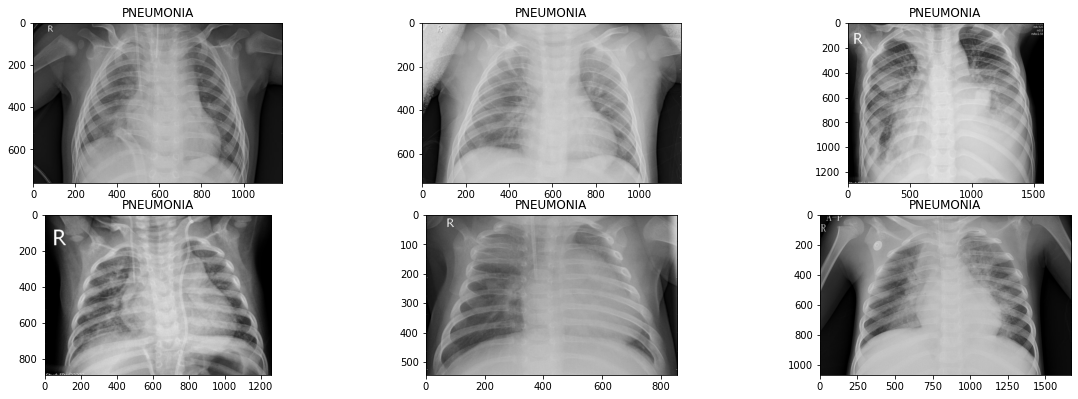

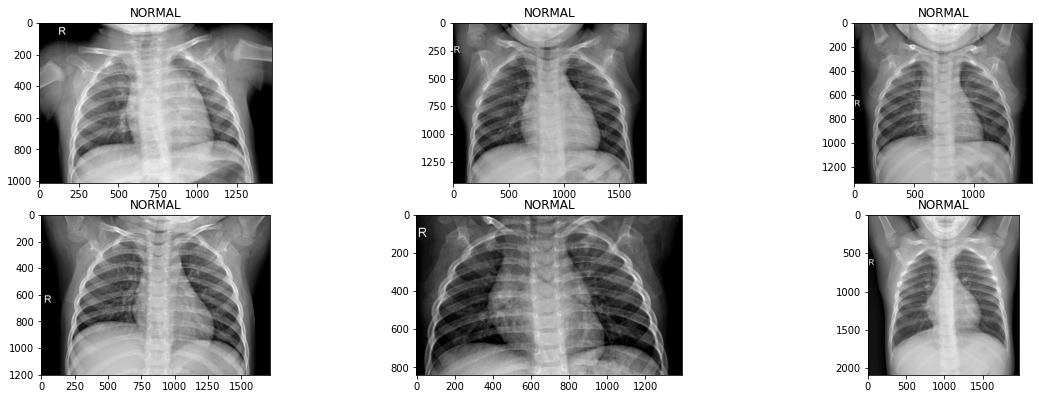

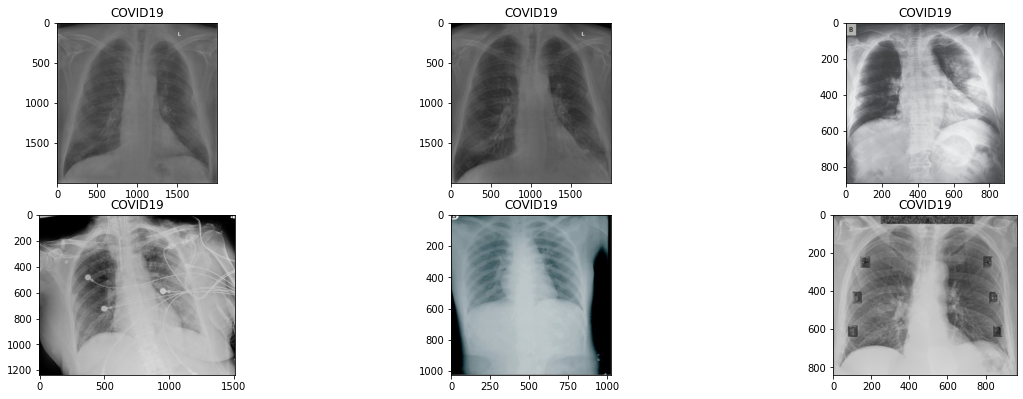

In [6]:
#plot to show the size of some image
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/PNEUMONIA",pneumona_images[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/NORMAL",normal_images[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/COVID19",covid_images[i])),cmap='gray')
    plt.title("COVID19")

In [7]:
train_datagen = ImageDataGenerator(
      horizontal_flip=True,
      rotation_range=10,
      zoom_range=0.4)

train_generator =train_datagen.flow_from_directory(
     train_image,
     batch_size= 256,
     shuffle=shuffle,
     target_size=(256, 256))

test_generator =train_datagen.flow_from_directory(
     test_image,
     batch_size= 50,
     shuffle=shuffle,
     target_size=(256, 256)) 

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [8]:
train_shape=train_generator.__getitem__(0)[0].shape
test_shape=test_generator.__getitem__(0)[0].shape
#Shape of Data
print("Train Shape \n",train_shape)
print("Test Shape \n",test_shape)

Train Shape 
 (256, 256, 256, 3)
Test Shape 
 (50, 256, 256, 3)


In [9]:
Labels={'NORMAL':0,'PNEUMONIA':1,'COVID19':2}

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x   
        
#Test        
print(getCode('COVID19'))
print(getLabel(1))

2
PNEUMONIA


In [10]:
#Reading image data
import glob as gb
import cv2  
size_image=256 # to resize the all image as same size

#to read all images from directory
def getData(Dir,size_image):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(size_image,size_image))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y

In [11]:
#get train data
X_train, y_train = getData(train_image,size_image)
# get test data
X_test , y_test = getData(test_image,size_image)

In [12]:
print("X_train Shape        ",X_train.shape)
print("X_test Shape         ",X_test.shape)

X_train Shape         (5144, 256, 256, 3)
X_test Shape          (1288, 256, 256, 3)


In [13]:
# #Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)

#Convert y_train to categorical
y_test=to_categorical(y_test,3)
print("y_test ",y_test.shape)

y_train  (5144, 3)
y_test  (1288, 3)


# Generalized Model 

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LeakyReLU #, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [15]:
def disease_prediction_model(pre_trained_model,file_name):
    for layer in pre_trained_model.layers:
        layer.trainable = False  #to make the layers to Freeze Weights
    pre_trained_model.summary()
    
    
    """
    model = Sequential()
    model.add(Flatten(pre_trained_model.output))
    #Full Connected Layers
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    #Add dropout to avoid Overfit
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    
    #Add dropout to avoid Overfit
    model.add(Dropout(0.4))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(3, activation='softmax'))
    #x=tf.keras.layers.Dense(3 , activation='softmax')(x) # Softmax

    """
    
    x = tf.keras.layers.Flatten()(pre_trained_model.output)

    #Full Connected Layers
    x = tf.keras.layers.Dense(512, activation=LeakyReLU(alpha=0.01))(x)
    #Add dropout to avoid Overfit
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation=LeakyReLU(alpha=0.01))(x) # Leaky ReLu
    x = tf.keras.layers.Dense(128, activation=LeakyReLU(alpha=0.01))(x) # Leaky ReLu
    #Add dropout to avoid Overfit
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation=LeakyReLU(alpha=0.01))(x) # Leaky ReLu


    x=tf.keras.layers.Dense(3 , activation='softmax')(x) # Softmax
    
    model = Model( pre_trained_model.input, x) 

    print(model.summary())
    model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
    
    epochs = 30
    history = model.fit_generator(train_generator, steps_per_epoch=2, epochs=epochs)
    
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    #Evaluate Model
    model.evaluate(test_generator)

    model.save(file_name+".h5")

    #prediction
    pred=model.predict(test_generator)
    print(len(pred))

    y_test=[]
    for i in range(26):
        y_test.extend(test_generator.__getitem__(i)[1])
        
    print(len(y_test))
    y_test=np.array(y_test)

    y_test=np.argmax(y_test,axis=1)
    pred= np.argmax(pred,axis=1)

    print("pred \n",len(pred))
    print("y_test \n",len(y_test))
    
    print("y_test \n",y_test)
    print("predicted \n",pred)
    
    cm=confusion_matrix(pred,y_test)
    print(cm)
    
    """
    plt.figure(figsize=(20,10))
    for i in range(0,9):

        plt.subplot(3, 3, i + 1)

        plt.imshow(test_generator.__getitem__(0)[0][i],cmap='gray')
        plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")

    """
    
    precision = precision_score(y_test,pred, average="weighted")
    print('Precision: %f' % precision)
    recall = recall_score(y_test,pred,average="weighted")
    print('Recall: %f' % recall)
    f1 = f1_score(y_test,pred,average="weighted")
    print('F1 score: %f' % f1)
    
    pass

In [16]:
from tensorflow.keras.applications import InceptionV3 as InceptionV3
from tensorflow.keras.applications import Xception as Xception
from tensorflow.keras.applications import ResNet50 as ResNet

87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2/2 [==============================] - 28s 8s/step - loss: 206.8608 - accuracy: 0.4870
Epoch 2/30
2/2 [==============================] - 20s 10s/step - loss: 237.0152 - accuracy: 0.5143
Epoch 3/30
2/2 [==============================] - 20s 10s/step - loss: 170.7244 - accuracy: 0.5026
Epoch 4/30
2/2 [==============================] - 19s 10s/step - loss: 147.1536 - accuracy: 0.4987
Epoch 5/30
2/2 [==============================] - 21s 11s/step - loss: 112.6164 - accuracy: 0.5716
Epoch 6/30
2/2 [==============================] - 20s 9s/step - loss: 86.7872 - accuracy: 0.5273
Epoch 7/30
2/2 [==============================] - 20s 10s/step - loss: 67.6768 - accuracy: 0.5651
Epoch 8/30
2/2 [==============================] - 21s 10s/step - loss: 67.3816 - accuracy: 0.6055
Epoch 9/30
2/2 [==============================] - 21s 12s/step - loss: 45.2561 - accuracy: 0.6250
Epoch 10/30
2/2 [==============================] - 20s 10s/step - loss: 42.4635 - accuracy: 0.5964
Epoch 11/30
2/2 

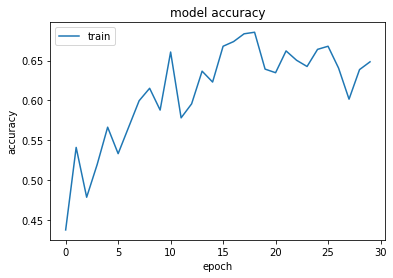

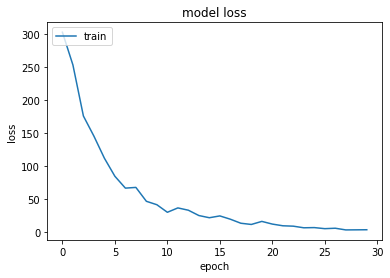

26/26 [==============================] - 50s 2s/step - loss: 0.8849 - accuracy: 0.7842
1288
1288
pred 
 1288
y_test 
 1288
y_test 
 [2 1 2 ... 2 1 2]
predicted 
 [1 1 2 ... 1 2 2]
[[  2   6  13]
 [ 40 103 227]
 [ 74 208 615]]
Precision: 0.532219
Recall: 0.559006
F1 score: 0.542467


In [17]:
pre_trained_model = InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(size_image,size_image,3), pooling=None, classes=3,
    classifier_activation='softmax'
)

disease_prediction_model(pre_trained_model,'Covid19-inception')

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2/2 [==============================] - 17s 12s/step - loss: 134.1438 - accuracy: 0.4651
Epoch 2/30
2/2 [==============================] - 21s 9s/step - loss: 213.2136 - accuracy: 0.4557
Epoch 3/30
2/2 [==============================] - 21s 10s/step - loss: 114.9146 - accuracy: 0.6172
Epoch 4/30
2/2 [==============================] - 21s 11s/step - loss: 117.0542 - accuracy: 0.5807
Epoch 5/30
2/2 [==============================] - 20s 10s/step - loss: 79.4470 - accuracy: 0.6445
Epoch 6/30
2/2 [==============================] - 20s 9s/step - loss: 94.0579 - accuracy: 0.6146
Epoch 7/30
2/2 [==============================] - 21s 10s/step - loss: 68.9543 - accuracy: 0.6159
Epoch 8/30
2/2 [==============================] - 21s 10s/step - loss: 54.8854 - accuracy: 0.7188
Epoch 9/30
2/2 [==============================] - 21s 10s/step - loss: 55.5757 - accuracy: 0.7214
Epoch 10/30
2/2 [==============================] - 21s 10s/step - loss: 43.1481 - accuracy: 0.6706
Epoch 11/30
2/2 [

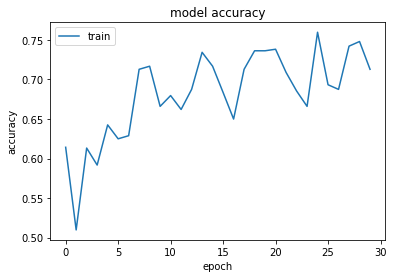

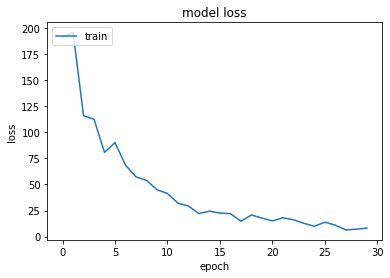

26/26 [==============================] - 51s 2s/step - loss: 2.0235 - accuracy: 0.8121
1288
1288
pred 
 1288
y_test 
 1288
y_test 
 [1 2 2 ... 1 1 2]
predicted 
 [1 2 2 ... 1 2 2]
[[ 10  23  60]
 [ 40 103 287]
 [ 66 191 508]]
Precision: 0.509449
Recall: 0.482143
F1 score: 0.492812


In [18]:
pre_trained_model = Xception(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(size_image,size_image,3), pooling=None, classes=3,
    classifier_activation='softmax'
)

disease_prediction_model(pre_trained_model,'covid19-xception')

94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2/2 [==============================] - 24s 9s/step - loss: 10.8547 - accuracy: 0.4154
Epoch 2/30
2/2 [==============================] - 21s 11s/step - loss: 31.1058 - accuracy: 0.4479
Epoch 3/30
2/2 [==============================] - 21s 11s/step - loss: 17.9818 - accuracy: 0.6185
Epoch 4/30
2/2 [==============================] - 11s 10s/step - loss: 11.3219 - accuracy: 0.6052
Epoch 5/30
2/2 [==============================] - 21s 10s/step - loss: 9.0486 - accuracy: 0.6380
Epoch 6/30
2/2 [==============================] - 21s 10s/step - loss: 10.4035 - accuracy: 0.6562
Epoch 7/30
2/2 [==============================] - 20s 10s/step - loss: 6.8791 - accuracy: 0.6549
Epoch 8/30
2/2 [==============================] - 20s 10s/step - loss: 6.6988 - accuracy: 0.6549
Epoch 9/30
2/2 [==============================] - 19s 9s/step - loss: 2.8871 - accuracy: 0.7799
Epoch 10/30
2/2 [==============================] - 20s 10s/step - loss: 2.6610 - accuracy: 0.7943
Epoch 11/30
2/2 [=========

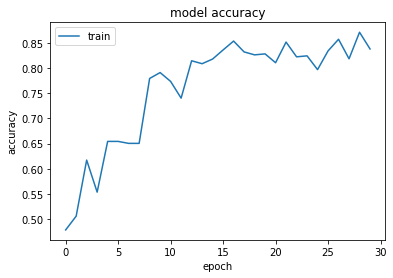

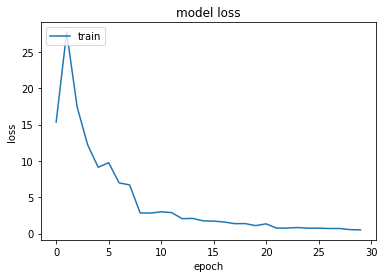

26/26 [==============================] - 51s 2s/step - loss: 0.2709 - accuracy: 0.8913
1288
1288
pred 
 1288
y_test 
 1288
y_test 
 [1 2 0 ... 2 2 2]
predicted 
 [1 2 2 ... 2 1 2]
[[ 10  32  75]
 [ 20  57 167]
 [ 86 228 613]]
Precision: 0.504159
Recall: 0.527950
F1 score: 0.514446


In [19]:
pre_trained_model = ResNet(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(size_image,size_image,3), pooling=None, classes=3,
    classifier_activation='softmax'
)

disease_prediction_model(pre_trained_model,'covid19-resnet')